In [1]:
# from astropy.time import Time
# from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
plt.style.use('default')
from scipy.signal import find_peaks, peak_prominences
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import GPy
from sklearn.metrics import mean_squared_error

In [19]:
full_data = np.load('sgrA.npz')
full_data = full_data['test']

In [20]:
import numpy as np

# Assuming `full_data` is the dataset of shape (num_examples, timesteps, channels * 2 + 1)
# For this example, we'll work with just one example (index 0) of `full_data`

example_idx = 0  # Choose the example you want to analyze
timesteps = np.arange(full_data.shape[1])  # Integer index for timesteps (0, 1, 2, ..., timesteps-1)
channels = (full_data.shape[-1] - 1) // 2  # Assuming 4 channels (X, NIR, IR, submm)

# Initialize empty lists to store unmasked and masked data
unmasked_data = []
masked_data = []

# Iterate through each channel to get unmasked and masked values
for channel_idx in range(channels):
    # The unmasked values are where the corresponding mask (channels + idx) is 1
    mask = full_data[example_idx, :, channels + channel_idx]  # Get the mask for this channel
    unmasked_indices = np.where(mask == 1)[0]  # Indices where the data is unmasked
    masked_indices = np.where(mask == 0)[0]  # Indices where the data is masked

    # Store unmasked values (timesteps and corresponding data values)
    unmasked_data.append({
        'X': timesteps[unmasked_indices],  # Unmasked timesteps (integer index)
        'Y': full_data[example_idx, unmasked_indices, channel_idx]  # Unmasked values
    })

    # Store masked values (timesteps and corresponding data values)
    masked_data.append({
        'X': timesteps[masked_indices],  # Masked timesteps (integer index)
        'Y': full_data[example_idx, masked_indices, channel_idx]  # Masked values
    })

# Now, unmasked_data contains X and Y for each channel
# For example:
X1, Y1 = unmasked_data[0]['X'], unmasked_data[0]['Y']  # X-ray
X2, Y2 = unmasked_data[1]['X'], unmasked_data[1]['Y']  # NIR
X3, Y3 = unmasked_data[2]['X'], unmasked_data[2]['Y']  # IR
X4, Y4 = unmasked_data[3]['X'], unmasked_data[3]['Y']  # submm

# Similarly, you can access the masked data if needed
X1_masked, Y1_masked = masked_data[0]['X'], masked_data[0]['Y']  # X-ray (masked)
X2_masked, Y2_masked = masked_data[1]['X'], masked_data[1]['Y']  # NIR (masked)
X3_masked, Y3_masked = masked_data[2]['X'], masked_data[2]['Y']  # IR (masked)
X4_masked, Y4_masked = masked_data[3]['X'], masked_data[3]['Y']  # submm (masked)

# You can now use X1, Y1, X2, Y2, ... for unmasked data and X1_masked, Y1_masked, ... for masked data


In [21]:
# Define kernels
K1 = GPy.kern.Bias(1)  # Bias kernel
K2 = GPy.kern.RBF(1)   # RBF kernel
K3 = GPy.kern.White(1)   # RBF kernel
K4 = GPy.kern.Matern32(1)

# Define lists
X_list = [X1.reshape(-1, 1), X2.reshape(-1, 1), X3.reshape(-1, 1), X4.reshape(-1, 1)]
Y_list = [Y1.reshape(-1, 1), Y2.reshape(-1, 1), Y3.reshape(-1, 1), Y4.reshape(-1, 1)]
kernel_list = [K2]

# LCM kernel with three outputs
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=5, kernels_list=kernel_list)

# Create the GP coregionalized regression model
model = GPy.models.GPCoregionalizedRegression(X_list=X_list, Y_list=Y_list, kernel=lcm)

# Optimize the model
model.optimize()

# Display model parameters
display(model)
print(model.param_array)


gp.,value,constraints,priors
ICM0.rbf.variance,0.03425094622484266,+ve,
ICM0.rbf.lengthscale,3.913806904962463,+ve,
ICM0.B.W,"(5, 1)",,
ICM0.B.kappa,"(5,)",+ve,
mixed_noise.Gaussian_noise_0.variance,0.018157741913229646,+ve,
mixed_noise.Gaussian_noise_1.variance,0.008528521537130504,+ve,
mixed_noise.Gaussian_noise_2.variance,0.070101635157842,+ve,
mixed_noise.Gaussian_noise_3.variance,0.010635320276883792,+ve,


[ 3.42509462e-02  3.91380690e+00  2.65365841e+00  2.87053189e+00
  6.94005126e-01  1.91614143e+00 -2.38343437e-01  1.24606385e-01
  2.15253431e-06  7.55044119e+00  3.11424669e+00  5.00000000e-01
  1.81577419e-02  8.52852154e-03  7.01016352e-02  1.06353203e-02]


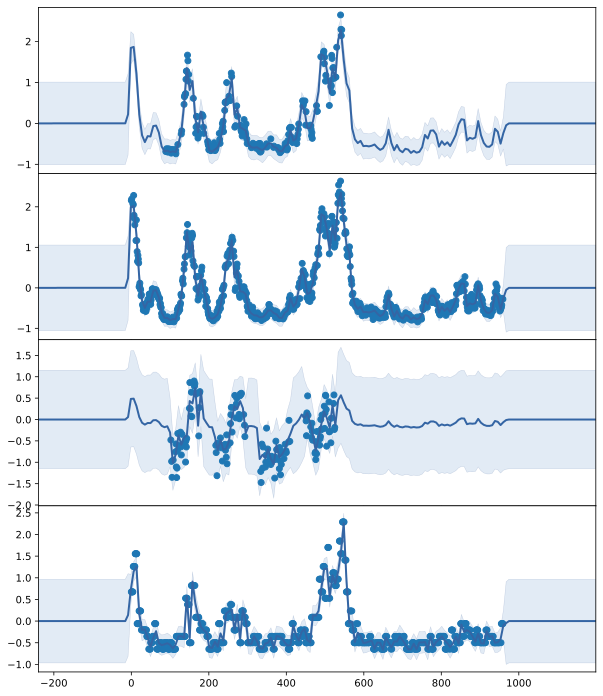

In [22]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(channels, hspace=0)
axs = gs.subplots(sharex=True)
X_list = [X1.reshape(-1, 1), X2.reshape(-1, 1), X3.reshape(-1, 1), X4.reshape(-1, 1)]
Y_list = [Y1.reshape(-1, 1), Y2.reshape(-1, 1), Y3.reshape(-1, 1), Y4.reshape(-1, 1)]
# y_labels = ['Chandra', 'VLT', 'Spitzer']

# Loop through each output and plot in its respective subplot
for i in range(channels):
    model.plot(plot_data = False, fignum=None, fixed_inputs=[(1, i)], ax=axs[i], legend=False)
    axs[i].scatter(X_list[i], Y_list[i])
    # axs[i].set_title()
    # axs[i].set_ylabel(y_labels[i])
    if i == 2:
        axs[i].set_xlabel('Input')